# Table of Contents
* [Stage 3 - load data](#Stage-3---load-data)
* [process data](#process-data)
* [region experiment](#region-experiment)
* [hide](#hide)


In [2]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import re
import pickle
import boto
from copy import deepcopy
import json
import os
import random
import jinja2
from tqdm import tqdm
from IPython.core.display import HTML

import PIL.Image as Image
import requests

from boto.mturk.qualification import PercentAssignmentsApprovedRequirement, Qualifications, Requirement

from keysTkingdom import mturk_ai2
from keysTkingdom import aws_tokes
from keysTkingdom import mturk_aristo

from amt_utils.mturk import pickle_this, unpickle_this

import os
import jinja2
import argparse
from jinja2 import Environment, FileSystemLoader

j2env = jinja2.Environment()

from amt_utils.bboxes import cluster_from_nms
from amt_utils.bboxes import draw_animation_seq
from amt_utils.bboxes import cluster_from_annos
from amt_utils.bboxes import create_subtask_data
from amt_utils.bboxes import draw_image_and_labels
from amt_utils.bboxes import select_labels
from amt_utils.bboxes import cluster_and_label
import warnings
warnings.filterwarnings('ignore')

import ai2.vision.utils as ai2vu

# Stage 3 - load data 

In [3]:
data_file_path = '../../build_dataset/stage_1_single_char_updated.pkl'
ds_stage_1 = unpickle_this(data_file_path)
ds_by_frame = {anno['globalID']: anno for anno in ds_stage_1}

In [4]:
stage_3_beta_1_res = unpickle_this('stage_3_beta_2.pkl')

In [5]:
stage_3_prod_1_res = unpickle_this('stage3a_prod_1_5k.pkl')

In [189]:
stage_3_prod_2_res = unpickle_this('stage3a_prod_2_5k.pkl')

In [6]:
# us_only_results = unpickle_this('stage_3_beta_us_only_results.pkl')
# nzaucaus_only_results = unpickle_this('stage_3_beta_nzaucaus_only_results.pkl')
# in_only_results = unpickle_this('stage_3_beta_in_only_results_results.pkl')
# stage_3a_gold_anno = unpickle_this('stage3a_gold_annotations.pkl')
# stage_3a_beta_1 = unpickle_this('stage_3a_beta_1.pkl')

# nzaucaus_hit_ids = set([hit for hit in nzaucaus_only_results])
# us_hit_ids = set([hit for hit in us_only_results])
# in_hit_ids = set([hit for hit in in_only_results])

# process data

In [7]:
def create_result(assmt):
    result = {}
    raw_result = json.loads(assmt.answers[0][0].fields[0])
    result['gif_uri'] = raw_result[0]['image_url']
    result['image_id'] = raw_result[0]['image_url'].rsplit('/', maxsplit=1)[-1][:-4]
    result['setting_description'] = raw_result[0]['description']
    result['asgmt_id'] = assmt.AssignmentId
    result['hit_id'] = assmt.HITId
    result['worker_id'] = assmt.WorkerId
    return result

In [31]:
turk_data = stage_3_prod_1_res
len(turk_data)

5000

In [191]:
stage_3_prod_1_asgmts = [item for sublist in stage_3_prod_1_res.values() for item in sublist]
stage_3_prod_1_results = [create_result(ar) for ar in stage_3_prod_1_asgmts]

In [200]:
stage_3_prod_all_asgmts = [item for sublist in stage_3_prod_2_res.values() for item in sublist]
stage_3_prod_all_results = [create_result(ar) for ar in stage_3_prod_all_asgmts]

In [201]:
prod_1_vids = set([vid['image_id'] for vid in stage_3_prod_1_results])
prod_all_vids = set([vid['image_id'] for vid in stage_3_prod_all_results])

In [202]:
prod_2_vids = prod_all_vids.difference(prod_1_vids)

In [203]:
len(prod_2_vids)

5893

In [204]:
prod_2_results = [vid for vid in stage_3_prod_2_results if vid['image_id'] in prod_2_vids]

In [32]:
assignments = [item for sublist in turk_data.values() for item in sublist]
assignment_results = [create_result(ar) for ar in assignments]

In [248]:
st3_df = pd.DataFrame(stage_3_prod_all_results)

In [249]:
st3_df['setting_description'] = st3_df['setting_description'].replace([None], ['missing'])

In [250]:
settings_per_turker.iloc[16]

image_id              s_01_e_01_shot_017622_017696
turker1  setting:                             room
turker2  setting:                             room
turker3  setting:                             room
Name: 16, dtype: object

In [251]:
setting_lookup = st3_df['setting_description']
setting_lookup.index = st3_df['image_id']

In [252]:
st3_df['setting_description'] = st3_df['setting_description'].apply(clean_response).values

In [253]:
st3_df.shape

(32626, 6)

In [254]:
st3_setting_counts = st3_df['setting_description'].value_counts()

In [255]:
frequent_settings = st3_setting_counts[st3_setting_counts <= 20 ]
frequent_settings = frequent_settings[frequent_settings > 5]

In [256]:
len(frequent_settings)

144

In [285]:
# fig = frequent_settings.plot(kind='barh', figsize=(38.5, 20.5))

In [258]:
# st3_setting_counts

1-5, 6-10, 11-20, 21-100, 100

In [259]:
r_tuples = [(1, 5), (6, 10), (11, 20), (21, 100), (100, np.inf)]
bin_counts = {}
bin_settings = defaultdict(list)
for r_tuple in r_tuples:
    lower_b = r_tuple[0]
    upper_b = r_tuple[1]
    f_range = st3_setting_counts[st3_setting_counts <=  upper_b]
    f_range = f_range[f_range >= lower_b]
    bin_key = 'bin: ' + str(lower_b) + '-' + str(upper_b)
    bin_settings[bin_key] = f_range.index.tolist()
    bin_counts[bin_key] = f_range.shape[0]

In [261]:
bin_settings_lookup = {}
for k, vals in bin_settings.items():
    for v in vals:
        bin_settings_lookup[v] = k

In [262]:
bin_settings_lookup['missing'] = 'bin: 1-5'

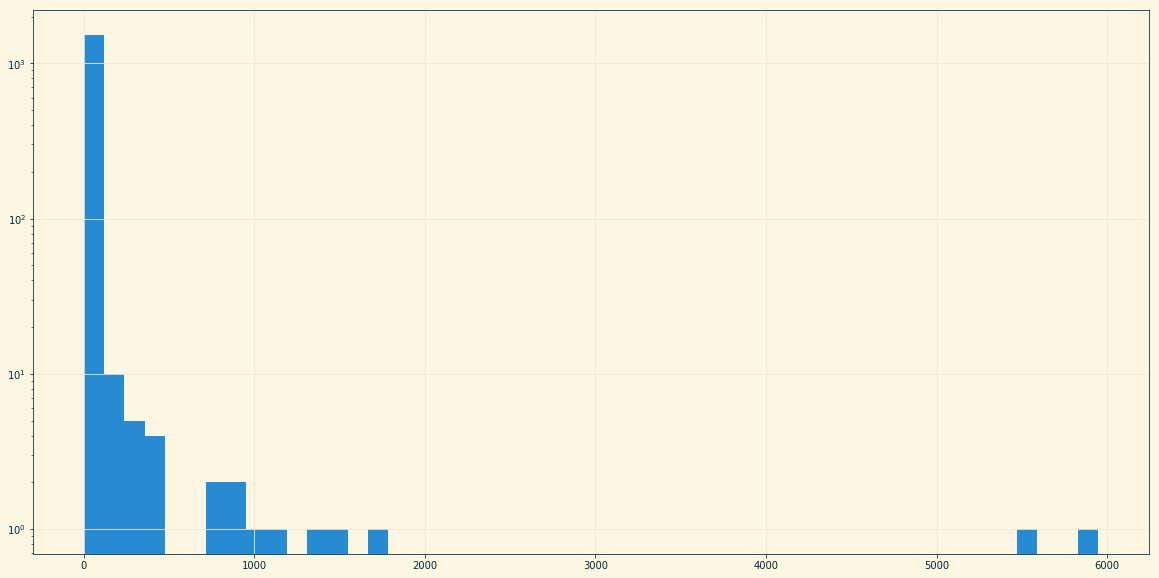

In [263]:
_ = st3_setting_counts.hist(log=True, bins = 50)

In [264]:
setting_freq_lookup = st3_df['setting_description'].value_counts().to_dict()
setting_freq_lookup['missing'] = 0

In [265]:
grouped_by_image = st3_df.groupby('image_id')

settings_per_turker = grouped_by_image['setting_description'].apply(lambda x: pd.Series(x.values)).unstack()
settings_per_turker = settings_per_turker.reset_index()
settings_per_turker.columns = ['image_id'] + ['turker{}  setting: '.format(i) for i in range(1, 4)]

In [266]:
settings_per_turker = settings_per_turker.replace([None], ['missing'])

In [267]:
def clean_response(resp_str):
    resp_str = resp_str.lower()
    resp_str = resp_str.replace('\n', ' ')
    resp_str = resp_str.strip()
    return resp_str

In [268]:
def select_string(resp_row):
    resp_mode = st.stats.mode(resp_row)
    if resp_mode.count[0] > 1:
        return resp_mode.mode[0]
    else:
        sorted_resp = sorted(resp_row.values.tolist(), key=lambda x: len(x))
        superset_resp = [resp for resp in sorted_resp[1:] if sorted_resp[0] in resp]
        if superset_resp:
            response_freqs = {k: setting_freq_lookup[k] for k in superset_resp + [sorted_resp[0]]} 
        else:
            response_freqs = {k: setting_freq_lookup[k] for k in sorted_resp} 
        return sorted(response_freqs.items(), key=lambda x: x[1], reverse=True)[0][0]
    

In [269]:
consensus_settings = settings_per_turker.iloc[:,1:].apply(select_string, axis=1)

In [270]:
consensus_settings.head()

0           room
1    living room
2        doorway
3           room
4        outside
dtype: object

In [271]:
cleaned_settings_per_turker = pd.concat([settings_per_turker['image_id'], settings_per_turker.iloc[:,1:].applymap(clean_response)], axis=1)

In [272]:
cleaned_settings_per_turker['consensus'] = consensus_settings

In [273]:
gif_uris = grouped_by_image['gif_uri'].agg(np.max)

In [274]:
cleaned_settings_per_turker = pd.merge(pd.DataFrame(gif_uris).reset_index(), cleaned_settings_per_turker)

In [275]:
cleaned_settings_per_turker.shape

(10893, 6)

In [276]:
cleaned_settings_per_turker.sample(200).to_csv('stage_3a_prod_2.csv')

In [277]:
consensus_settings.apply(lambda x: bin_settings_lookup[x]).value_counts()

bin: 100-inf    10089
bin: 21-100       522
bin: 11-20        140
bin: 1-5           72
bin: 6-10          70
dtype: int64

In [280]:
prod_1_setting = cleaned_settings_per_turker[['image_id', 'consensus']]

In [281]:
prod_1_setting.index = prod_1_setting['image_id']

In [283]:
pickle_this(prod_1_setting['consensus'].to_dict(), 'stage3_prod1_2_settings.pkl')

# region experiment

In [27]:
# turk_data = {**us_only_results, **in_only_results, **nzaucaus_only_results}

In [194]:
def lookup_region(hitid):
    if hitid in nzaucaus_hit_ids:
        return 'nzaucaus'
    if hitid in us_hit_ids:
        return 'us only'
    if hitid in in_hit_ids:
        return 'in only'

In [195]:
# st3_df['region'] = st3_df['hit_id'].apply(lookup_region)

In [374]:
st3_df.head(1)

,asgmt_id,gif_uri,hit_id,image_id,setting_description,worker_id
0,3907X2AHF15BOY9UZP8DW6BDJFLP2S,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3K8CQCU3KF1UA9XU7SFQR4RM1M0NWT,s_06_e_23_shot_018951_019025,room,A3HHDPKL3O3O7Y


In [379]:
grouped_by_image = st3_df.groupby('image_id')

settings_per_turker = grouped_by_image['setting_description'].apply(lambda x: pd.Series(x.values)).unstack()
settings_per_turker = settings_per_turker.reset_index()
settings_per_turker.columns = ['image_id'] + ['turker{}  setting: '.format(i) for i in range(1, 4)]

In [393]:
settings_per_turker

,image_id,turker1 setting:,turker2 setting:,turker3 setting:
0,s_01_e_03_shot_036331_036405,quarry,quarry,Quarry
1,s_01_e_04_shot_020768_020842,room,Living room,Quarry
2,s_01_e_04_shot_036045_036119,Doorway,doorway,Entry way
3,s_01_e_05_shot_006248_006322,inside house,Dining room,table inside\n
4,s_01_e_06_shot_033979_034053,Outside,outside,outside
5,s_01_e_07_shot_027719_027793,sidewalk,street,roadway
6,s_01_e_08_shot_035035_035109,living room,Living room,living room
7,s_01_e_10_shot_002849_002923,living room,room,inside house
8,s_01_e_10_shot_028169_028243,room,green room,indoors
9,s_01_e_11_shot_000814_000888,living room,living room,living room


In [355]:
# settings_per_region = grouped_by_image['setting_description'].apply(lambda x: pd.Series(x.values)).unstack()
# actions_per_region = grouped_by_image['character_description'].apply(lambda x: pd.Series(x.values)).unstack()
# region_s = grouped_by_image['region'].apply(lambda x: pd.Series(x.values)).unstack()

# region_cols = region_s.iloc[0][[0, 1, 2]].values.tolist()

# settings_per_region.columns = ['setting: ' + reg for reg in region_cols]
# actions_per_region.columns = ['actions: ' + reg for reg in region_cols]
# settings_per_region = settings_per_region.reset_index()
# actions_per_region = actions_per_region.reset_index()

In [388]:
gif_uris = grouped_by_image['gif_uri'].agg(np.max)

In [394]:
settings_per_turker

,image_id,turker1 setting:,turker2 setting:,turker3 setting:
0,s_01_e_03_shot_036331_036405,quarry,quarry,Quarry
1,s_01_e_04_shot_020768_020842,room,Living room,Quarry
2,s_01_e_04_shot_036045_036119,Doorway,doorway,Entry way
3,s_01_e_05_shot_006248_006322,inside house,Dining room,table inside\n
4,s_01_e_06_shot_033979_034053,Outside,outside,outside
5,s_01_e_07_shot_027719_027793,sidewalk,street,roadway
6,s_01_e_08_shot_035035_035109,living room,Living room,living room
7,s_01_e_10_shot_002849_002923,living room,room,inside house
8,s_01_e_10_shot_028169_028243,room,green room,indoors
9,s_01_e_11_shot_000814_000888,living room,living room,living room


In [397]:
beta_reponses_df = pd.merge(pd.DataFrame(gif_uris).reset_index(), settings_per_turker)

In [398]:
beta_reponses_df

,image_id,gif_uri,turker1 setting:,turker2 setting:,turker3 setting:
0,s_01_e_03_shot_036331_036405,https://s3-us-west-2.amazonaws.com/ai2-vision-...,quarry,quarry,Quarry
1,s_01_e_04_shot_020768_020842,https://s3-us-west-2.amazonaws.com/ai2-vision-...,room,Living room,Quarry
2,s_01_e_04_shot_036045_036119,https://s3-us-west-2.amazonaws.com/ai2-vision-...,Doorway,doorway,Entry way
3,s_01_e_05_shot_006248_006322,https://s3-us-west-2.amazonaws.com/ai2-vision-...,inside house,Dining room,table inside\n
4,s_01_e_06_shot_033979_034053,https://s3-us-west-2.amazonaws.com/ai2-vision-...,Outside,outside,outside
5,s_01_e_07_shot_027719_027793,https://s3-us-west-2.amazonaws.com/ai2-vision-...,sidewalk,street,roadway
6,s_01_e_08_shot_035035_035109,https://s3-us-west-2.amazonaws.com/ai2-vision-...,living room,Living room,living room
7,s_01_e_10_shot_002849_002923,https://s3-us-west-2.amazonaws.com/ai2-vision-...,living room,room,inside house
8,s_01_e_10_shot_028169_028243,https://s3-us-west-2.amazonaws.com/ai2-vision-...,room,green room,indoors
9,s_01_e_11_shot_000814_000888,https://s3-us-west-2.amazonaws.com/ai2-vision-...,living room,living room,living room


In [399]:
# per_region_df['char_name'] = per_region_df['image_id'].apply(lambda x: ds_by_frame[x]['characters'][0]['characterName'])

In [400]:
# pickle_this(set(per_region_df['image_id'].tolist()), 'random_sample_ids.pkl')

In [403]:
beta_reponses_df.to_csv('stage_3a_beta_1.csv')

In [402]:
# annotations_by_frame = defaultdict(list)
# for anno in sorted(assignment_results, key=lambda x: x['stillID']):
#     animation_id = anno['stillID'].rsplit('_', 1)[0]
#     annotations_by_frame[animation_id].append(anno)

# hide

In [35]:
# s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'

In [28]:
# pickle_this(setting_lookup.to_dict(), 'stage_3_beta_gold_settings.pkl')

In [19]:
# import PIL.Image as Image
# import requests

# image_n = 10


# s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'

# image_url = s3_base_path + 's_01_e_04_shot_012010_012084_70.png'
# Image.open(requests.get(image_url, stream=True).raw)